In [1]:
%load_ext autoreload
%autoreload 2
import neptune as n
import copy
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
from image_registration import chi2_shift
from image_registration.fft_tools import shift
from astropy.io import fits

In [2]:
# first, average the flats
rerun_flats = False
if rerun_flats:
    medflats = n.process_flats()
else:
    medflats = n.retrieve_flats()

In [3]:
# first, average the sciences
sciences = n.divide_flats(n.get_sciences(), medflats)
sciences = n.renorm_and_crop_all(sciences, do_renorm=True)
# viewing the images and looking for Neptune shows us we should use
# 0 1 2 4 for H
# 0 1 2 4 for J (no 3 exists so you'll index into this as 0 1 2 3)
# 1 2 3 4 for Ks
science_medians = {}
for k in n.filternames:
    science_medians[k] = np.nanmedian(sciences[k], axis=0)
    for i in range(4):
        sciences[k][i] -= science_medians[k]

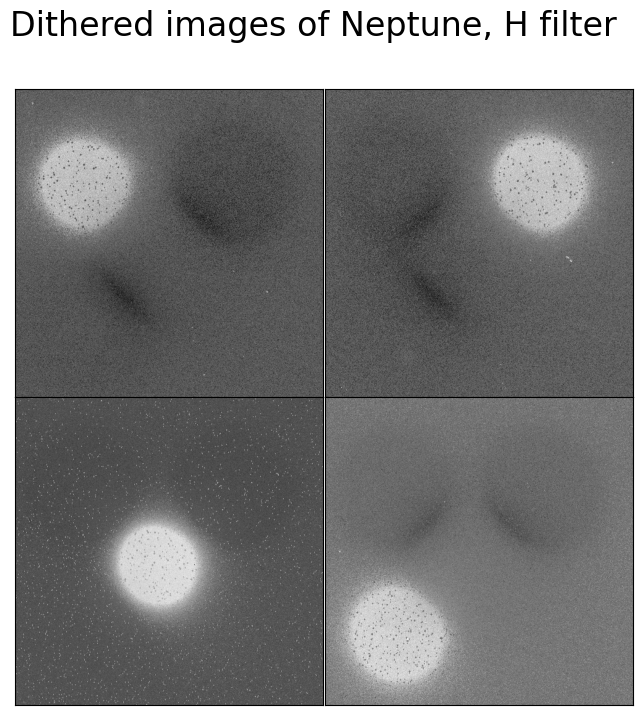

In [13]:
n.plot_all_images(sciences, "H", "Dithered")
plt.savefig("uncorr_H.png")

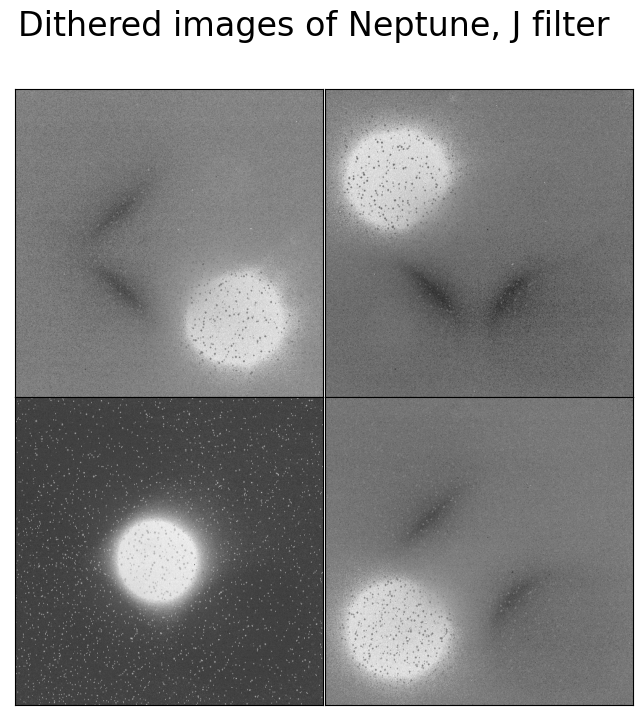

In [16]:
n.plot_all_images(sciences, "J", "Dithered")
plt.savefig("uncorr_J.png")

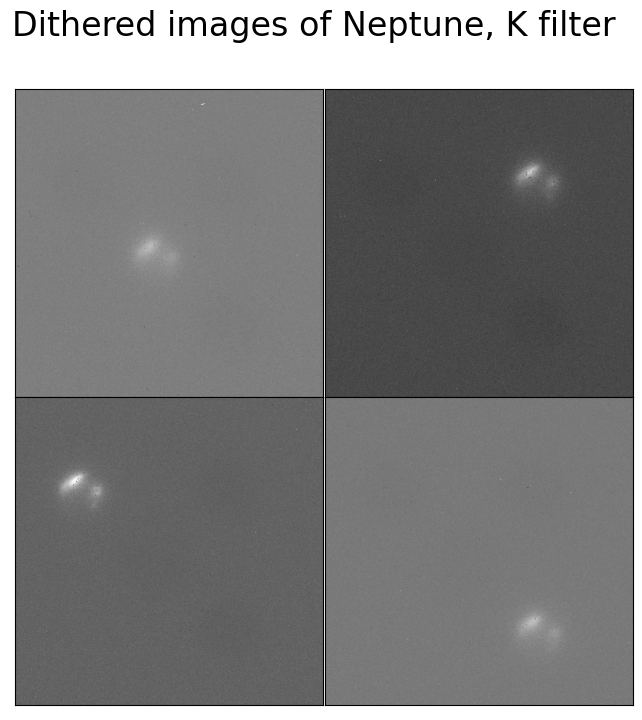

In [17]:
n.plot_all_images(sciences, "K", "Dithered")
plt.savefig("uncorr_K.png")

In [8]:
offsets = {k : np.zeros((4, 2)) for k in n.filternames}
offset_sciences = {k : [] for k in n.filternames}
for k in offsets:
    for i in range(4):
        offsets[k][i] = chi2_shift(sciences["H"][0], sciences[k][i])[:2]

# offsets["K"] = (offsets["J"] + offsets["H"]) / 2

for k in offsets:
    for i in range(4):
        dx, dy = offsets[k][i]
        offset_sciences[k].append(shift.shiftnd(sciences[k][i], (-dy, -dx)))

/Users/adityasengupta/opt/anaconda3/envs/astr257/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


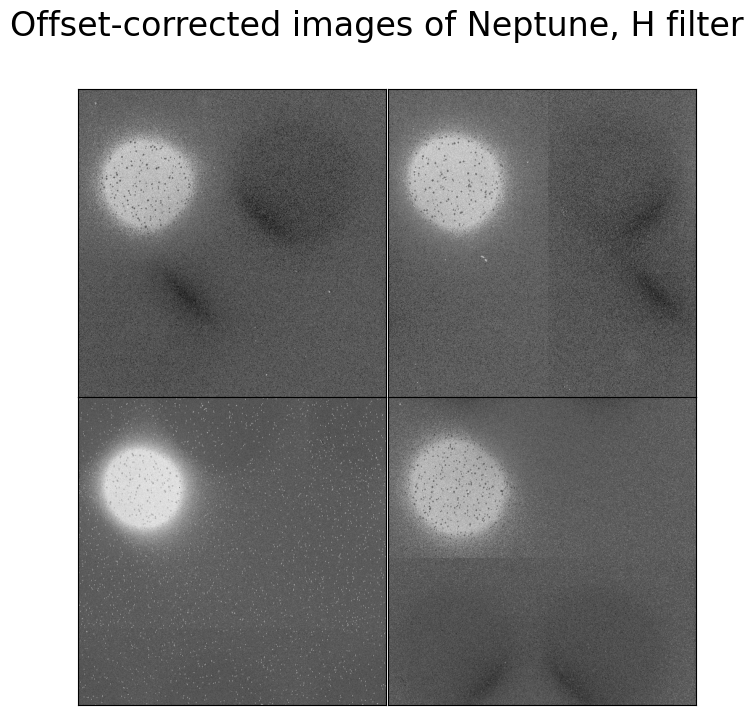

In [18]:
n.plot_all_images(offset_sciences, "H", "Offset-corrected")
plt.savefig("corr_H.png")

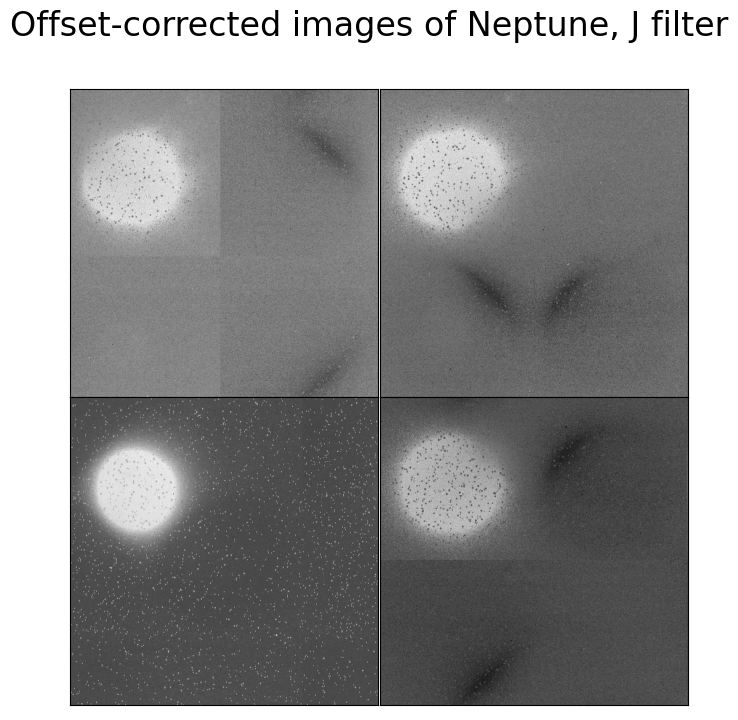

In [19]:
n.plot_all_images(offset_sciences, "J", "Offset-corrected")
plt.savefig("corr_J.png")

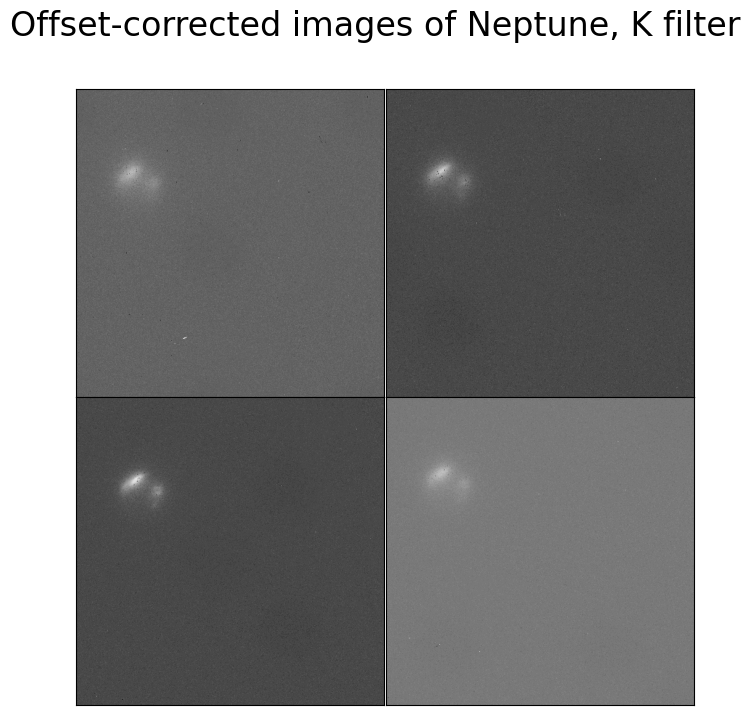

In [20]:
n.plot_all_images(offset_sciences, "K", "Offset-corrected")
plt.savefig("corr_K.png")

In [12]:
avg_img = lambda f, i: np.mean(offset_sciences[f][:i], axis=0)

In [229]:
for f in n.filternames:
    fits.writeto(f"neptune_{f}.fits", avg_img(f, 4), overwrite=True)

# fits.writeto(f"neptune_K.fits", avg_img("K", 1), overwrite=True)